# Определение возраста покупателей


## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы
* Контролировать добросовестность кассиров при продаже алкоголя

### Описание задачи

Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

### Этапы решения поставленной задачи
* Проведеение исследовательского анализа
* Подготовка данных к обучению
* Обучение нейронной сети

## Исследовательский анализ данных

### Импортируем необходимые для работы библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

### Загрузим имеющиеся данные

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Изучим распределение возрастов в имеющейся для работы выборке

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Минимальные и максимальные значения возраста вопросов не вызывают, как и средний с медианным.

Построим график

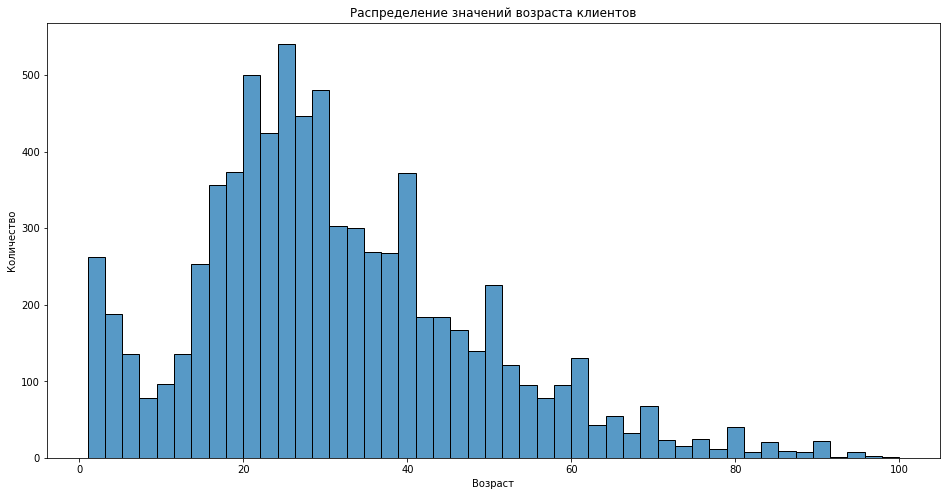

In [8]:
plt.figure(figsize=(16,8))
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.title('Распределение значений возраста клиентов')
ax = sns.histplot(labels['real_age'])

plt.show()

Много фотографий детей, распределение нормальное,  люди поживого возраста тоже имеются.



### Рассмотрим небольшую выборку из имеющихся фото.

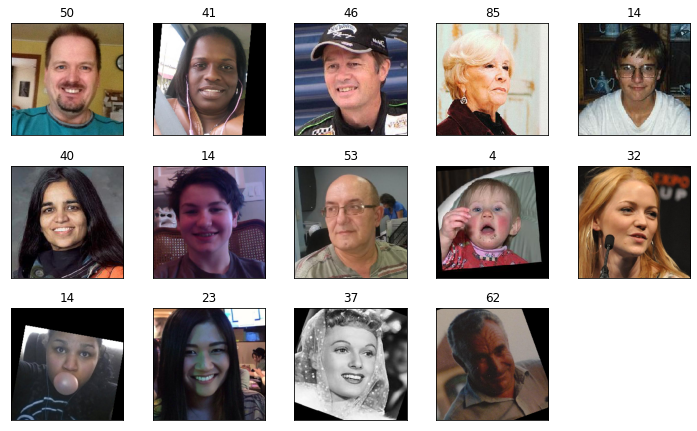

In [9]:
features, target = next(gen_flow)

pic = plt.figure(figsize=(10,10))
for i in range(14):
    pic.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

Фото реалистичные, лицо находиться в центре, возраст сопоставим с фото. Имеются некоторые фото где лицо сложно распознать.

### Вывод по исследовательскому анализу

* В нашем распоряжении 7591 фото
* Возраст соответствует фотографии
* В имеющейся подборке представлены люди от 1 до 100 лет, что даст возможность модели хорошо обучиться, и не получить пробелов в знании
* Некоторые фото плохого качаества, не в смысле разрешения, а искажены или лицо плохо видно

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    datagen  = ImageDataGenerator(horizontal_flip=True, rescale=1/255., validation_split=0.25)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae',optimizer=optimizer,metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-07-25 05:38:33.002085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-25 05:38:33.557588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 66s - loss: 10.8126 - mae: 10.8134 - val_loss: 20.3606 - val_mae: 20.3530
Epoch 2/5
356/356 - 43s - loss: 7.4524 - mae: 7.4524 - val_loss: 10.2890 - val_mae: 10.2867
Epoch 3/5
356/356 - 43s - loss: 6.5483 - mae: 6.5482 - val_loss: 6.8360 - val_mae: 6.8383
Epoch 4/5
356/356 - 43s - loss: 5.9347 - mae: 5.9348 - val_loss: 7.3459 - val_mae: 7.3436
Epoch 5/5
356/356 - 47s - loss: 5.3473 - mae: 5.3476 - val_loss: 7.3305 - val_mae: 7.3310
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 7.3305 - mae: 7.3310
Test MAE: 7.3310

```

## Анализ обученной модели

Модель неплохо справляется с поставленной задачей  mae  в среднем 7.3, на обучающей выборке 5.35.

В заданные рамки данные значения входят. Повысить точность модели можно увеличением количества эпох, но нужно следить, за переобучением, так же еще немного поиграть с learning rate. Но из-за сложности процесса обучения и реализации от этого можно отказаться. Ошибка в возрасте +- 7 лет дает нам возможность предугадывать возрастную группу покупателей и правильно предлагать товар, а насчет продажи алкоголя такая ошибка сильно ограничивает применение модели. 

Следовательно данную модель лучше применять в рамках предложения товаров соответствующим возрастным группам, а проверку на возраст при продаже товаров 18+ данная модель провести не сможет, ее точность нужно сильно повышать до mae 0.5, поскольку продажа таких товаров даже 17-летним покупателям является серьезным нарушением закона.

Что бы исправить это можно добавить в начальную выборку больше фотографий подростков поскольку их количество судя по графику сильно меньше взрослой возрастной группы. 
